# House Prices - Advanced Regression Techniques

This is a notebook for predicting house prices using regression techniques. The notebook includes data preprocessing, feature engineering, and model training. We will use Kaggle datasets for this task. 

We are going to use a stacking regressor model, which combines multiple regression models to improve prediction accuracy. The notebook will also include visualizations of the data and model performance.
The regression models used in this notebook include:
- Linear Regression
- Random Forest Regressor
- Gradient Boosting Regressor
- XGBoost Regressor
- LightGBM Regressor

In [3]:
import pandas as pd
import torch 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

test_data = pd.read_csv('data/test.csv')
train_data = pd.read_csv('data/train.csv')


In [3]:
# Sort column names alphabetically and print them
sorted_columns = sorted(train_data.columns)
for column in sorted_columns:
    print(column)


1stFlrSF
2ndFlrSF
3SsnPorch
Alley
BedroomAbvGr
BldgType
BsmtCond
BsmtExposure
BsmtFinSF1
BsmtFinSF2
BsmtFinType1
BsmtFinType2
BsmtFullBath
BsmtHalfBath
BsmtQual
BsmtUnfSF
CentralAir
Condition1
Condition2
Electrical
EnclosedPorch
ExterCond
ExterQual
Exterior1st
Exterior2nd
Fence
FireplaceQu
Fireplaces
Foundation
FullBath
Functional
GarageArea
GarageCars
GarageCond
GarageFinish
GarageQual
GarageType
GarageYrBlt
GrLivArea
HalfBath
Heating
HeatingQC
HouseStyle
Id
KitchenAbvGr
KitchenQual
LandContour
LandSlope
LotArea
LotConfig
LotFrontage
LotShape
LowQualFinSF
MSSubClass
MSZoning
MasVnrArea
MasVnrType
MiscFeature
MiscVal
MoSold
Neighborhood
OpenPorchSF
OverallCond
OverallQual
PavedDrive
PoolArea
PoolQC
RoofMatl
RoofStyle
SaleCondition
SalePrice
SaleType
ScreenPorch
Street
TotRmsAbvGrd
TotalBsmtSF
Utilities
WoodDeckSF
YearBuilt
YearRemodAdd
YrSold


In [4]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

In [4]:
from sklearn.model_selection import train_test_split

X = train_data.drop(columns=['SalePrice'], axis=1).copy()
y = train_data['SalePrice'].copy()

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

train_data = X_train.join(y_train)
val_data = X_val.join(y_val)


In [7]:
val_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 292 entries, 892 to 722
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             292 non-null    int64  
 1   MSSubClass     292 non-null    int64  
 2   MSZoning       292 non-null    object 
 3   LotFrontage    250 non-null    float64
 4   LotArea        292 non-null    int64  
 5   Street         292 non-null    object 
 6   Alley          17 non-null     object 
 7   LotShape       292 non-null    object 
 8   LandContour    292 non-null    object 
 9   Utilities      292 non-null    object 
 10  LotConfig      292 non-null    object 
 11  LandSlope      292 non-null    object 
 12  Neighborhood   292 non-null    object 
 13  Condition1     292 non-null    object 
 14  Condition2     292 non-null    object 
 15  BldgType       292 non-null    object 
 16  HouseStyle     292 non-null    object 
 17  OverallQual    292 non-null    int64  
 18  OverallCond  

Text(0.5, 0, 'Sale Price')

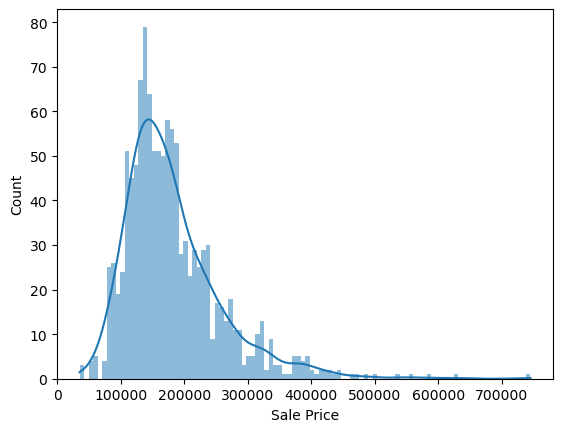

In [8]:
sns.histplot(train_data['SalePrice'], bins=100, kde = True, linewidth=0)
plt.xlabel('Sale Price')

In [5]:
numerical_values = train_data.select_dtypes(include=[np.number])

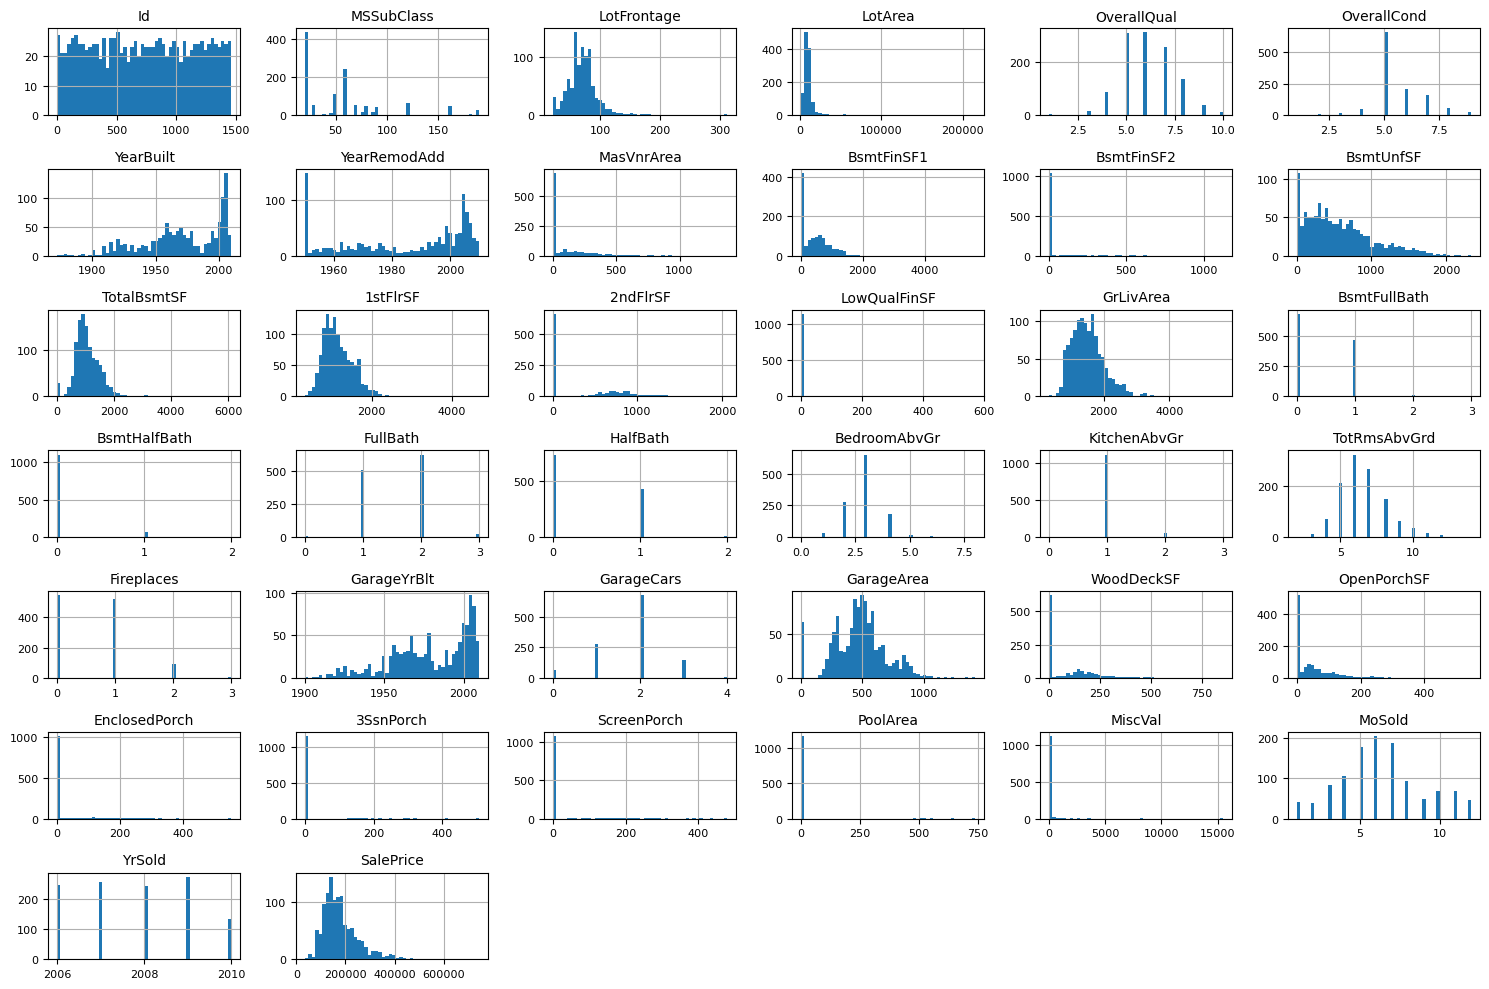

In [ ]:
numerical_values.hist(figsize=(15, 10), bins=50, xlabelsize=8, ylabelsize=8)
for ax in plt.gcf().axes:
    ax.set_title(ax.get_title(), fontsize=10)
plt.tight_layout()
plt.show()

In [12]:
numerical_values.info() 

<class 'pandas.core.frame.DataFrame'>
Index: 1168 entries, 254 to 1126
Data columns (total 38 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1168 non-null   int64  
 1   MSSubClass     1168 non-null   int64  
 2   LotFrontage    951 non-null    float64
 3   LotArea        1168 non-null   int64  
 4   OverallQual    1168 non-null   int64  
 5   OverallCond    1168 non-null   int64  
 6   YearBuilt      1168 non-null   int64  
 7   YearRemodAdd   1168 non-null   int64  
 8   MasVnrArea     1162 non-null   float64
 9   BsmtFinSF1     1168 non-null   int64  
 10  BsmtFinSF2     1168 non-null   int64  
 11  BsmtUnfSF      1168 non-null   int64  
 12  TotalBsmtSF    1168 non-null   int64  
 13  1stFlrSF       1168 non-null   int64  
 14  2ndFlrSF       1168 non-null   int64  
 15  LowQualFinSF   1168 non-null   int64  
 16  GrLivArea      1168 non-null   int64  
 17  BsmtFullBath   1168 non-null   int64  
 18  BsmtHalfBat

In [4]:
numerical_values.drop(columns=['Id'], inplace=True)

### Feature Engineering and Data Visualization (Pipeline)

Since features like LotArea, GrLivArea, SalePrice, TotalBsmtSF, 1stFlrSF are highly right-skewed, we will pply log1p transform (np.log1p(x)) to reduce skewness and make distribution more Gaussian-like.

This should improve model performance, especially for linear models and some tree-based ones.

We will then find outliers using Z-score method and remove them from the dataset.



In [ ]:
from sklearn.base import BaseEstimator, TransformerMixin

'''Custom transformers for preprocessing the numerical features of the dataset'''

class LogTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, min_prop = 0.05, columns =["LotArea", "GrLivArea", "SalePrice", 
                                "TotalBsmtSF", "1stFlrSF", "LotFrontage",
                                "GarageArea", "ScreenPorch",
                                "BsmtUnfSF", "MasVnrArea", "BsmtFinSF1",
                                "BsmtFinSF2", "OpenPorchSF",]):
        self.min_prop = min_prop
        self.columns = columns


    def fit(self, X, y=None):
        self.sparse_columns = []
        for col in self.columns:
            value_counts = X[col].value_counts(normalize=True)
            zero_prop = value_counts.get(0, 0.0)
            if zero_prop >= self.min_prop: 
                self.sparse_columns.append(col)
        return self

    def transform(self, X):
        X = X.copy()
        if self.columns is not None:
            for col in self.columns:
                X[col] = np.log1p(X[col])
                if col in self.sparse_columns:
                    X[f"has_{col}"] = (X[col] > 0).astype(int)
        return X

class dropColumns(BaseEstimator, TransformerMixin):
    def __init__(self, columns=["MiscVal", "Alley", "PoolQC", "BsmtFinType2"]):
        """Initializes the dropColumns transformer with specified columns to drop.
        """
        self.columns = columns

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X = X.copy()
        for col in self.columns:
            if col in X.columns:
                X.drop(columns=col, inplace=True)
        return X

class AgeCalculator(BaseEstimator, TransformerMixin):
    def __init__(self, columns=["YrSold", "YearBuilt"]):
        self.columns = columns

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X = X.copy()
        X["HouseAge"] = (X[self.columns[0]] - X[self.columns[1]]).astype(int)
        X["HouseAge"] = X["HouseAge"].clip(lower=0)
        return X

class FeatureImputer(BaseEstimator, TransformerMixin):
    def __init__(self, columns_zeros=[], columns_none = []):
        self.columns_zeros = columns_zeros
        self.columns_none = columns_none

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X = X.copy()
        for col in self.columns_zeros:
            X[col] = X[col].fillna(0)
        for col in self.columns_none:
            X[col] = X[col].fillna("None")
        return X

class OutliersRemoval(BaseEstimator, TransformerMixin):
    def __init__(self, rows_indexes =[1182, 1298, 1169, 224, 1190]):
        self.rows_indexes = rows_indexes 
        
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        X = X.copy()
        # Remove rows with specified indexes
        for index in self.rows_indexes:
            if index in X.index:
                X = X.drop(index=index, errors='ignore')
        return X.reset_index(drop=True)
    
class YearImputer(BaseEstimator, TransformerMixin):
    def __init__(self, column="GarageYrBlt", fill_value= None):
        self.column = column
        self.fill_value = fill_value
       
    def fit(self, X, y=None):
        if self.fill_value is None:
            self.fill_value = X[self.column].median()
        return self

    def transform(self, X):
        X = X.copy()
        X["GarageYrBlt_missing"] = (X[self.column]).isna().astype(int)
        X[self.column] = X[self.column].fillna(self.fill_value)
        return X

class HighlyCorrelatedFeatures(BaseEstimator, TransformerMixin):
    """We will check if highly correlated feature with SalePrice exceed a threshold of 3.0, and if so, we will remove them from the dataset.
    The threshold is simply an absolute Person-r-cutoff value of 0.8, which is a common practice in data analysis to identify highly correlated features.
    """
    def __init__(self, threshold=0.85):
        self.threshold = threshold
        self.columns_to_drop = []

    def fit(self, X, y=None):
        corr_matrix = X.corr().abs()
        mask = np.triu(np.ones(corr_matrix.shape), k=1).astype(bool)
        upper = corr_matrix.where(mask)
        self.to_drop_ = [col for col in upper.columns if any(upper[col] > self.threshold)]
        return self

    def transform(self, X):
        X = X.copy()
        return X.drop(columns=self.columns_to_drop, errors='ignore')


#### Outliers Detection 

Outliers are detected using Z-score method, which is a common statistical method to identify outliers in a dataset. The Z-score is calculated as the number of standard deviations a data point is from the mean of the dataset. If the absolute value of the Z-score is greater than a certain threshold (commonly 3), the data point is considered an outlier.

We want a dataframe that contains the zscore for each value in the specified columns, and then we will filter out the rows where the absolute zscore is greater than 3.

Each zscore is calculated as follows:

$$
z_{i,j} = \frac{x_{i,j} - \mu_j}{\sigma_j},
\quad
\mu_j = \frac{1}{n}\sum_{i=1}^n x_{i,j},
\quad
\sigma_j = \sqrt{\frac{1}{n}\sum_{i=1}^n (x_{i,j} - \mu_j)^2}.
$$



In [ ]:
from ydata_profiling import ProfileReport

profile = ProfileReport(numerical_values, title="House Prices Regression Data Profiling Report", explorative=True)
profile.to_file("house_prices_regression.html")

In the html file `house_prices_regression.html`, we can find the data profiling report which includes the Z-score for each value in the specified columns. The report also provides insights into the distribution of the data, missing values, and other statistical properties.



In [14]:
from scipy.stats import zscore 

def get_outlier_table(numerical_values: pd.DataFrame, thresh: float = 3.0):

    zscores  = pd.DataFrame(zscore(numerical_values, nan_policy="omit"), 
                            columns=numerical_values.columns, 
                            index=numerical_values.index)

    # 2) Stack to long format: rows × columns → one row per cell
    long = (zscores.stack().reset_index().rename(columns={
            "level_0": "row_index",
            "level_1": "feature",
            0: "z_score"}))

    # 3) Filter to only the “extreme” cells
    outliers = long[long["z_score"].abs() > thresh].copy()
    # 5) Sort by descending |z_score| so the worst outliers rise to the top
    outliers = outliers.reindex(
        outliers["z_score"].abs().sort_values(ascending=False).index
    ).reset_index(drop=True)
    return outliers

# Example: run on your training set
outlier_table = get_outlier_table(numerical_values, thresh=3.0)

for feature in ["LotArea", "GrLivArea", "SalePrice",
                                "TotalBsmtSF", "1stFlrSF", "LotFrontage",
                                "GarageArea", "ScreenPorch",
                                "BsmtUnfSF", "MasVnrArea", "BsmtFinSF1",
                                "BsmtFinSF2", "OpenPorchSF"]:
    if feature in outlier_table["feature"].values: 
        print(outlier_table[outlier_table["feature"] == feature].head(10))
# Inspect the top 10 worst outliers


def get_outliers_list(outlier_table: pd.DataFrame, n: int = 10):
    """Returns a list of the indexes of the top n outliers from the outlier table."""
    return outlier_table.head(n)["row_index"].tolist()


     row_index  feature    z_score
1          313  LotArea  19.019985
6          335  LotArea  14.316486
7          249  LotArea  13.790207
24         706  LotArea   9.712849
88        1298  LotArea   4.946402
130       1396  LotArea   4.324630
271        769  LotArea   3.980968
276        457  LotArea   3.955212
279        384  LotArea   3.944055
328         53  LotArea   3.680357
     row_index    feature   z_score
38        1298  GrLivArea  7.849169
63         523  GrLivArea  6.006390
69        1182  GrLivArea  5.624862
203       1169  GrLivArea  4.005276
272        185  GrLivArea  3.969031
305        304  GrLivArea  3.749653
331       1268  GrLivArea  3.661901
345        635  GrLivArea  3.562704
386        769  GrLivArea  3.341418
405       1353  GrLivArea  3.263205
     row_index    feature   z_score
43        1182  SalePrice  7.297097
67        1169  SalePrice  5.743307
80         803  SalePrice  5.198613
98         440  SalePrice  4.836929
108        769  SalePrice  4.616809
196

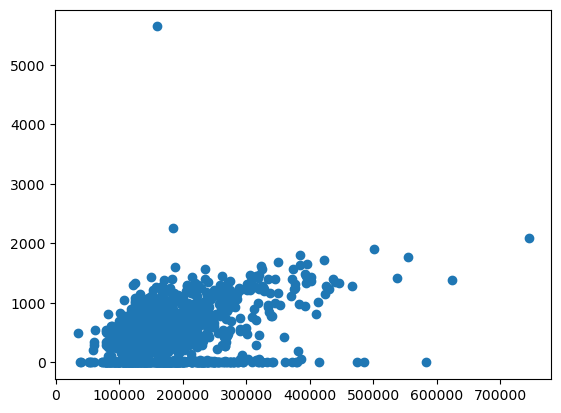

In [15]:
plt.scatter(x="SalePrice", y="BsmtFinSF1", data=train_data)

In [16]:
train_data.query("SalePrice > 500000")
#1182, 1298, 1169

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
1182,1183,60,RL,160.0,15623,Pave,NaN,IR1,Lvl,AllPub,...,555,Ex,MnPrv,NaN,0,7,2007,WD,Abnorml,745000
178,179,20,RL,63.0,17423,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,7,2009,New,Partial,501837
440,441,20,RL,105.0,15431,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,4,2009,WD,Normal,555000
1169,1170,60,RL,118.0,35760,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,7,2006,WD,Normal,625000
803,804,60,RL,107.0,13891,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,1,2009,New,Partial,582933
769,770,60,RL,47.0,53504,Pave,NaN,IR2,HLS,AllPub,...,0,NaN,NaN,NaN,0,6,2010,WD,Normal,538000


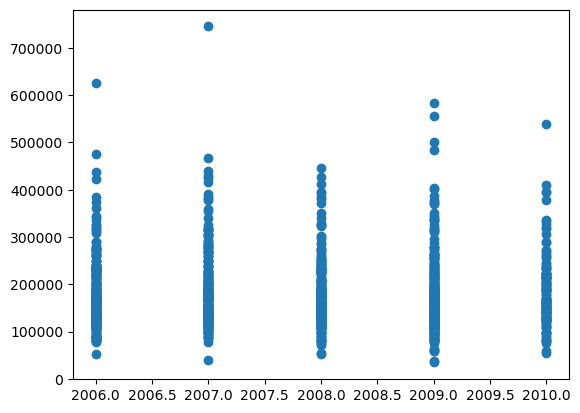

In [17]:
plt.scatter(x="YrSold", y="SalePrice", data=train_data)

In [6]:
pd.DataFrame(train_data.isnull().sum(), columns=['Null Count']).sort_values(by='Null Count', ascending=False).head(20)

,Null Count
PoolQC,1162
MiscFeature,1122
Alley,1094
Fence,935
MasVnrType,683
FireplaceQu,547
LotFrontage,217
GarageYrBlt,64
GarageCond,64
GarageType,64


BsmtExposure, BsmtCond, BsmtQual, GarageQual, GarageFinish, GarageType, GarageCond, FireplaceQu, MasVnrType

In [ ]:
# We used this cell to manually inspect the unique values of different columns
train_data["MasVnrType"].unique()

array([nan, 'BrkFace', 'Stone', 'BrkCmn'], dtype=object)

In [ ]:
# We used this cell to manually fill some missing values in the dataset
train_data["BsmtFinType2"] = train_data["BsmtFinType2"].fillna("Unf")


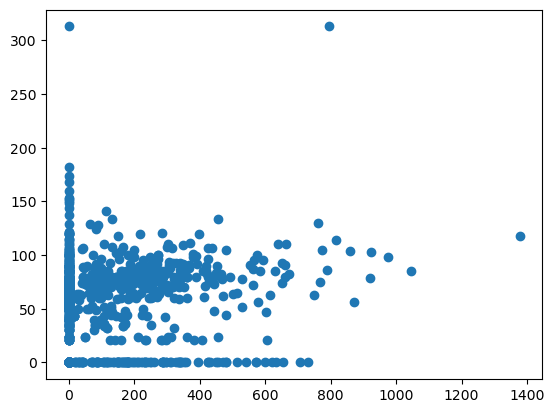

In [62]:
plt.scatter(x="MasVnrArea", y="LotFrontage", data=train_data)

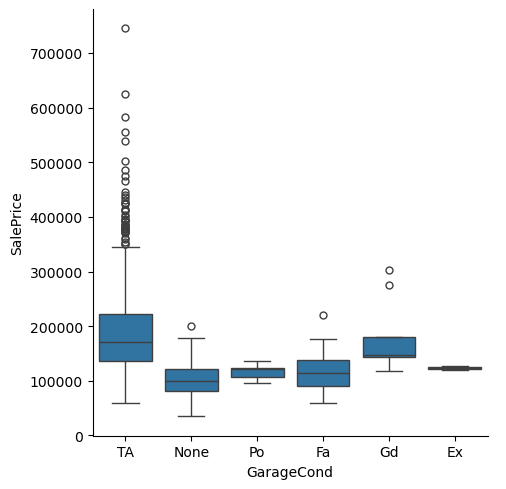

In [74]:
sns.catplot(x="GarageCond", y="SalePrice", data=train_data, kind="box")

In [60]:
'''Inspecting categorical features and their unique values'''

# Get all categorical columns
categorical_columns = train_data.select_dtypes(include=['object']).columns

# Create a list to store dictionaries with column info
column_info = []

# Populate the list
for col in categorical_columns:
    unique_vals = train_data[col].unique()
    column_info.append({'Feature': col, 'Unique_Values': list(unique_vals)})

# Create DataFrame from the list
feature_values_df = pd.DataFrame(column_info)

# Display the resulting dataframe
# Set pandas display options to show all values without truncation
pd.set_option('display.max_colwidth', None)
feature_values_df.head(5)   

,Feature,Unique_Values
0,MSZoning,"[RL, RM, FV, RH, C (all)]"
1,Street,"[Pave, Grvl]"
2,Alley,"[nan, Pave, Grvl]"
3,LotShape,"[Reg, IR1, IR2, IR3]"
4,LandContour,"[Lvl, Bnk, HLS, Low]"


In [ ]:

# Features for one-hot encoding (nominal categorical variables)
one_hot_features = ["SaleType", "MiscFeature", "PavedDrive", "GarageType", "Electrical", 
                    "CentralAir", "Heating", "Foundation", "MasVnrType", "RoofMatl", 
                    "Exterior2nd", "RoofStyle", "HouseStyle", "BldgType",
                    "Condition2", "Condition1", "Neighborhood", "LotConfig", "LotShape", 
                    "Street", "MSZoning", "SaleCondition"]

# Features for ordinal encoding (categorical variables with inherent order)
ordinal_features = ["GarageCond", "GarageQual", "GarageFinish", "FireplaceQu", 
                    "Functional", "KitchenQual", "HeatingQC", "BsmtFinType2", "BsmtFinType1", 
                    "BsmtExposure", "BsmtCond", "BsmtQual", "ExterCond", "ExterQual",
                    "LandSlope", "Utilities", "LandContour"]

In [ ]:
ordinal_features_dict = { "GarageCond":  ["Po", "Fa", "TA", "Gd", "Ex", "NA"],
                        "GarageQual":  ["Po", "Fa", "TA", "Gd", "Ex", "NA"],
                        "FireplaceQu": ["Po", "Fa", "TA", "Gd", "Ex", "NA"],
                        "KitchenQual": ["Po", "Fa", "TA", "Gd", "Ex"],
                        "HeatingQC":   ["Po", "Fa", "TA", "Gd", "Ex"],
                        "BsmtCond":    ["Po", "Fa", "TA", "Gd", "Ex", "NA"],
                        "BsmtQual":    ["Po", "Fa", "TA", "Gd", "Ex", "NA"],
                        "ExterCond":   ["Po", "Fa", "TA", "Gd", "Ex"],
                        "ExterQual":   ["Po", "Fa", "TA", "Gd", "Ex"],
                        "GarageFinish": ["NA", "Unf", "RFn", "Fin"],
                        "Functional": ["Sal", "Sev", "Maj2", "Maj1", "Mod", "Min2", "Min1", "Typ"],
                        "BsmtFinType1": ["NA", "Unf", "LwQ", "Rec", "BLQ", "ALQ", "GLQ"],
                        "BsmtFinType2": ["NA", "Unf", "LwQ", "Rec", "BLQ", "ALQ", "GLQ"],
                        "BsmtExposure": ["NA", "No", "Mn", "Av", "Gd"],
                        "LandSlope": ["Gtl", "Mod", "Sev"],
                        "Utilities": ["ELO", "NoSeWa", "NoSewr", "AllPub"],
                        "LandContour": ["Lvl", "Bnk", "HLS", "Low"],}

In [ ]:
'''More feature engineering: 
- CategoricalEncoder: One-hot and ordinal encoding for categorical features.
- TotalArea: Calculate total square footage of the house.
- TotalBaths: Calculate total number of bathrooms in the house.
'''

class CategoricalEncoder(BaseEstimator, TransformerMixin):
    def __init__(self, one_hot_features=[], ordinal_features_dict={}):
        self.one_hot_features = one_hot_features or []
        self.ordinal_features_dict = ordinal_features_dict or {}

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X = X.copy()
        # One-hot encoding for nominal categorical variables
        if self.one_hot_features:
            X = pd.get_dummies(X, columns=self.one_hot_features, drop_first=True)
        
        # Ordinal encoding for categorical variables with inherent order
        if self.ordinal_features_dict:
            for column, ordered_levels in self.ordinal_features_dict:
                if col in X.columns:
                    categories_levels= pd.api.types.CategoricalDtype(
                    categories=ordered_levels, ordered=True)
                X[column] = X[column].astype(categories_levels)
                
        return X

class TotalArea(BaseEstimator, TransformerMixin):
    """Transformer to calculate the total square footage of the house."""
    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X = X.copy()
        X["TotalSF"] = (X["TotalBsmtSF"] + X["GrLivArea"])
        X.drop(columns=["TotalBsmtSF", "GrLivArea"], inplace=True, errors='ignore')
        return X
    
class TotalBaths(BaseEstimator, TransformerMixin):
    """Transformer to calculate the total number of bathrooms in the house."""
    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X = X.copy()
        X["TotalBaths"] = (X["FullBath"] + 0.5 * X["HalfBath"] + 
                           X["BsmtFullBath"] + 0.5 * X["BsmtHalfBath"])
        X.drop(columns=["FullBath", "HalfBath", "BsmtFullBath", "BsmtHalfBath"], inplace=True, errors='ignore')
        return X


<Axes: >

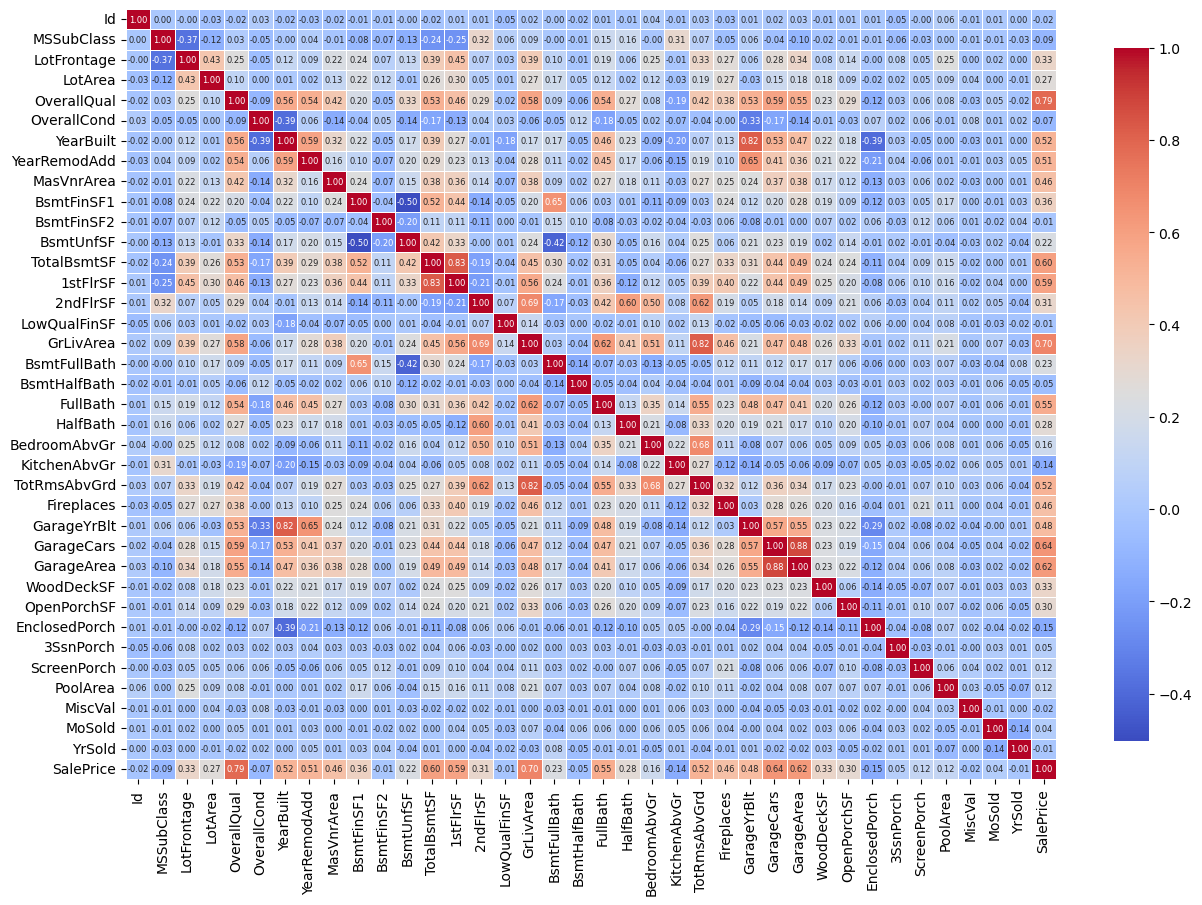

In [ ]:
plt.figure(figsize=(15, 10))
sns.heatmap(numerical_values.corr(), linewidth=0.4, annot=True, fmt=".2f", 
            cmap="coolwarm", annot_kws={"size": 6}, cbar_kws={"shrink": .9})

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

'''Pipeline for preprocessing the dataset'''

# List of features that will be filled with "None" if they are missing
none_fill_features: list = ["BsmtExposure", "BsmtCond", "BsmtQual", "GarageQual", 
                            "GarageFinish", "GarageType", "GarageCond", 
                            "FireplaceQu", "MasVnrType"]

# Function to return steps of a pipeline excluding specified names
def steps_without(pipe, *names):
    """Return a list of (name, step) tuples excluding any in *names."""
    return [s for s in pipe.steps if s[0] not in names]
# Create a pipeline for numerical features

pipeline_num = Pipeline([
    ("drop_columns", dropColumns(columns=["Id"])),
    ("log_transformer", LogTransformer()),
    ("age_calculator", AgeCalculator()),
    ("feature_imputer", FeatureImputer(["LotFrontage", "MasVnrArea"], none_fill_features)),
    ("outliers_removal", OutliersRemoval()),
    ("year_imputer", YearImputer()),
    ("total_area", TotalArea()),
    ("total_baths", TotalBaths()),
    ("standard_scaler", StandardScaler()),
    ("highly_correlated_features", HighlyCorrelatedFeatures(threshold=0.9))])

# Create separate pipelines for numerical and categorical features
pipeline_cat = Pipeline([("categorical_encoder", 
                               CategoricalEncoder(one_hot_features=one_hot_features, 
                                                  ordinal_features_dict=ordinal_features_dict)),
                        ("drop_columns", dropColumns(columns=["Id"]))])

# Exclude the outliers_removal step for validation data
pipeline_val_num = Pipeline(
    steps_without(pipeline_num, "outliers_removal"))  

# Exclude the outliers_removal step for validation data
# Exclude the last step (HighlyCorrelatedFeatures)
pipeline_test_cat = Pipeline(pipeline_cat.steps[:-1]) # Exclude the last step (Drop "id" column)
pipeline_test_num = Pipeline(
    steps_without(pipeline_num, "drop_columns", "outliers_removal")) 

# Extract categorical and numerical features from the datasets
cat_val_features = val_data.select_dtypes(include=['object']).copy()
num_val_features = val_data.select_dtypes(include=[np.number]).copy()
test_cat_raw = test_data.select_dtypes(include=['object']).copy()
test_num_raw = test_data.select_dtypes(include=[np.number]).copy()

# Fit the pipeline to the various datasets
# Stacking the numerical and categorical features using .join()
train_df = pd.DataFrame(pipeline_num.fit_transform(numerical_values), 
                                  columns=pipeline_num[-1].columns.get_feature_names_out(), 
                                  index=train_data.index).join(
                                      pd.DataFrame(pipeline_cat.fit_transform(categorical_columns), 
                                  columns=pipeline_cat[-1].get_feature_names_out(), 
                                  index=train_data.index)
                                  )
val_df = pd.DataFrame(pipeline_val_num.transform(num_val_features), 
                                    columns=pipeline_num[-1].columns.get_feature_names_out(), 
                                    index=val_data.index).join(
                                        pd.DataFrame(pipeline_cat.transform(cat_val_features), 
                                    columns=cat_val_features.columns.get_feature_names_out(), 
                                    index=val_data.index)
                                    )
test_df = pd.DataFrame(pipeline_test_cat.transform(test_cat_raw),
                                    columns=pipeline_test_cat[-1].columns.get_feature_names_out(), 
                                    index=test_data.index).join(
                                        pd.DataFrame(pipeline_test_num.transform(test_num_raw),
                                    columns=pipeline_test_num[-1].columns.get_feature_names_out(), 
                                    index=test_data.index)
                                    )
X_train = train_df.drop(columns=["SalePrice"], axis=1)
y_train = train_df["SalePrice"].copy()